<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/vgg_vs_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Final Project - Emotion Recognition 

I used deep learning to conduct emotion recognition on image data, by using the Facial Emotion Recognition (FER 2013) dataset. FER-2013 is one of the most popular openly-available emotion datasets, where images are labeled as one of 7 emotions. I performed transfer learning by using two different CNN architectures: ResNet50 and VGG16. Both architectures have been pretrained on Image Net, which is a visual database of more than 14 million hand-annotated images. I will fine-tune the models to FER2013 to compare performance and derive useful insights from training both networks.


## **Loading and Preparing the Data**

FER-2013 is a dataset containing 35,887 close-up images of human faces available. The photos are 48x48 grayscale images. FER2013 is one of the largest emotional expressions dataset openly available on Kaggle; it is well-studied but challenging to train on. Human-level accuracy has only been approximately 65%, and the best CNN architectures have reached approximately 75% accuracy. The classes are: [Angry, Happy, Sad, Fearful, Surprised, Disgusted, Neutral].

This cateogiration assumes Paul Ekman's emotion theory. As one of the most famous emotion psychologists, Paul Ekman proposed the idea that there are 6-8 basic, universal emotions that people feel no matter where they are from, and these emotions can be inferred from their facial expressions. There have been strong criticisms against this theory, for it's simplicity and shaky empirical evidence, but Paul Ekman is one of the cited emotion psychologists in computer vision because his theory fits the machine learning (classification) framework most conveniently of all the emotion theories so far. Other emotion theories, such as those that support multi-modal input for inferring emotions pose serious constraints on computational processing as well as finding good quality and widely-available data for different demographics. 

Regardless, in this assignment, FER2013 will be utilized. In order to do so, I perform the following processing steps to prepare the data for training. 

**1. Imitating RGB** 

FER2013 photos are grayscale, whereas both ResNet50 and VGG16 require a 3-channel RGB input to the neural network architecture. In order to emulate this, we can layer the grayscale with two additional channels that are duplicates of the original grayscale channel. Since the image will be the same overall three channels, the performance of the neural network should be the same as it was on RGB images.

**2. Class Imbalance**

FER2013 is a highly imbalanced dataset.  In FER-2013, the highest number of samples belong to the class “Happiness” with 7000 images, and the smallest class is the “Disgust” class with only a couple of hundred training samples. Most other classes are between 5000 and 3000 training samples. The State of The Art for VGG16 and ResNet50 both included using balanced datasets to improve misclassification rates for certain classes. In my implementation, I trained with both balanced and imbalanced data to understand how performance differs. 

Class imbalance is an important issue to address because it can render the accuracy metric an unreliable measure of classification performance. This is because the model can learn to predict the majority class for all examples and still end up with a high accuracy, which will deprioritize the model’s tendency to accurately predict minority classes. In order to deal with this issue, I chose the method of data resampling to balance out the class distribution. This includes undersampling the majority class of “Happiness”, and oversampling the minority class of “Disgust”.

**3. Data Augmentation** 

I performed data augmentation using sklearn's ImageGenerator method in order to deal with overfitting. I used the following steps to augment data. 






## Model Training

### Optimization 

I used the Stochastic Gradient Descent optimizer with momentum. SGD differs from vanilla gradient descent because instead of running over all samples to update a paramater in an iteration, it only uses one or a subset of training samples. When using a subset, it is called mini-batch gradient descent. This makes it much faster than normal batch gradient descent, because SGD needs a much smaller set of training sample(s) to start improving. As such, a whole dataset does not need to be held in the RAM and vectorization can be more efficient.   

The stochastic in SGD refers to randomness, whereby random samples from the training data are chosen to update parameter during optimization. This means that instead of smooth learning curve, it will be much noisier. The benefit of this is that it can snap or jerk the learning out of local minima and increase the chances of it finding the global minimum. This is more appropriate for FER2013, because it is a challenging dataset to train on and does not have a smooth error manifold that is convex. The randomness, as such, is good for helping the model move out of local basins of attractions. 

The momentum in SGD can help take care of the instability introduced by the randomness, by accelerating the gradient descent in the relevant direction i.e. speed up movement in directions of strong improvement. The Nesterov momentum is a variation on momentum where if the gradient and momentum are pointing in different directions, is nesterov is set to True, then it redirects momentum in the right direction. 

## **VGG16**

VGG was proposed in 2014 by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group in Oxford University, hence the name VGG. The unique thing about VGG that made it a success at the time was that it used very small convolutional filters of 3x3, which allowed it to push the depth of the neural network to 16-19 layers without running into limitations the previous models ran into such as too many parameters. 

### Compiling VGG16

I froze all layers in VGG16 and added multiple fully-connected dense layers at the end with relu activations, as well as a softmax layer. The choice of nodes in the FC layers is consistent with the SOTA implementation.

### Training VGG16

At first, there was serious overfitting during training, with training accuracy at 90% contrasted with validation and test accuracy plateaued in the 40-45% range. In order to counter this, I added 30% dropout. This significantly decreased overfitting during training, which may explain the large variance in FER2013. To combat overfitting further, I performed training on augmented data using sklearn's Image Generator. At first, this led to very slow training because the data augmentation would be performed on the CPU whereas the training would happen on GPU. In order to deal with this issue, I turned multi-processing on and increased the worker size to 10, which allowed the augmentation and training to take place in parallel. Moreover, I increased batch size from 32 to 128, which significantly decreased training time from hours to minutes per epoch. This further decreased overfitting to the point that there was little difference between training and validation accuracy. Moreover, it slightly improved the model performance from 42% to 46%.  However, despite decrease in overfitting, model performance did not improve significantly. 


### Testing VGG16

use saliency maps and error analyses 

## **ResNet50**
### Compiling ResNet50

I loaded the pre-trained ResNet50 model that was trained on the Image Net dataset, and then froze the first 165 layers. I then added some additional dense layers to increase the depth of the model, with 'he Uniform' kernel initialization, which samples from a uniform distribution between $ (-\sqrt(6 / x), \sqrt(6 / x)) $ where x are the number of inputs in the weight tensor. Moreover, I added batch normalization layers. Batch Normalization is a effective in mini-batch gradient descent because it reparameterizes the distributions for each layer with a standardized mean of 0 and a standard deviation of 1 (Gaussian). This takes care of the problem of "internal covariate shift", which basically means that the model gets adjusted to different distributions in each layer and gets destabilized. By taking care of this issue, the learning algorithm is stabilized and can be expected to learn faster. Moreover, I added some dropout layers with 50% dropout. This reduced the number of trainable parameters from 15 million to 4 million, by randomly dropping nodes from some layers.

For the loss function, I used the sparse categorical cross-entropy loss, since my class labels are integers instead of one-hot encoded categorical representations. 


### Training ResNet50

After compiling the model, I ran it on the training data with a variable learning rate and an early stopping option. If the validation loss did not improve after a few epochs, the learning rate would be decayed by 10% to introduce sensitivity into the learning process. This would ensure that the model is not missing the local minimum. Moreover, the training would stop early using the Early Stopping function in Keras if no improvement happens over 15 epochs. I observed relatively overfitting even after adding 50% dropout to the FC layers and rebalancing the dataset. This could be improved by adding more data augmentations. 

### Testing ResNet50

My model achieved an accuracy of 53.20%, which is lower than the benchmark of 72.4% for FER2013 with ResNet50.

One of the advantages of using ResNet50 is that it is a very deep model, with hundreds of sequential layers. However, unlike other very deep neural networks such as VGG, ResNet50 does not have the problem of vanishing gradients, which is to be expected in deep models where after backpropagating through the deep architecture, the gradients become zero prematurely and leave the initial layers unchanged. This is not a problem in ResNet50 because it has skip connections, which the gradients can flow directly from later layers to initial layers.

Since ResNet50 was trained on imagenet, which is a large database of images in the wild, FER2013 is just a collection of facial expressions, which means that instead of using weights from pretraining on general image data, if we could access a model that was also pre-trained on image data, then it could potentially increase the ability of the model to learn the nuances between facial expressions of people. Currently, the model knows how to tell lots of different kinds of things apart in image data, but is not necessarily concerned with telling faces apart that well. Perhaps, a face recognition dataset is more appropriate because once a model is well-acquainted with telling faces apart, we could use transfer learning to train it in telling variations in facial expressions apart. The SOTA implementation was directly done on VGGFace instead of VGG16, where the weights were more attuned to faces. This may explain the difference in performance. 

In transfer learning, one of the things that improved training was altering the batch sizes. Decreased batch sizes yielded better results on the validation set, which could be because smaller batches are more noisy, so they can help the model generalize better by not attuning to the noise or getting stuck in local minima. Smaller batch sizes are also better with using the SGD optimizer. 


## **Comparing VGG16 and ResNet50** 

## **References**

Ruiz, P. (2018, October 8). Understanding and visualizing ResNets - Towards Data Science. Medium; Towards Data Science. https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

‌Khaireddin, Y., & Chen, Z. (n.d.). Facial Emotion Recognition: State of the Art Performance on FER2013. Retrieved March 29, 2022, from https://arxiv.org/pdf/2105.03588.pdf

Brownlee, J. (2019, January 15). A Gentle Introduction to Batch Normalization for Deep Neural Networks. Machine Learning Mastery. https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

## **Appendices**

### **HC and LO Applications** 

**#deeplearning**

**#advanceddeeplearning**

**#optimization**

**#**

**#**

**#**

### **Code** 

In [1]:
## for preprocessing
import pandas as pd
import os
import shutil
import math 
import numpy as np
import random 

## For plotting
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
from IPython.display import Image
%matplotlib inline


## For machine learning
import keras
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential, Model 
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers import Dropout, Activation, Flatten, GlobalAveragePooling2D 
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
###### PNG --> NUMPY CONVERSION of FER2013

#get file paths for training and test images
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

#initialize lists to save data
train_data = []
train_label = []
test_data = []
test_label = []

#y label encoding in a dictionary
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

def unison_shuffled_copies(a, b):
    '''Shuffles two arrays in sync using permutations.'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  '''Converts png images into numpy arrays with their labels and stores them in a shuffled array.

  Input:
  folder_path - Path to folder where images for each emotion are stored in a different folder
  label_dict - Dictionary of labels and their encodings   

  Output:
  data -  Array of image arrays
  label - Array of image labels 
  '''

  data = []
  label = []
  for category in os.listdir(folder_path): 
    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      #image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)

  data = np.array(data)
  label = np.array(label)
  data, label = unison_shuffled_copies(data, label)
  return data, label

#get test and training data in numpy array format from png files
train_data, train_label = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label = get_image_arrays(test_path, emotion_dictionary)

#save test and training set for future use 
np.savez('/content/drive/MyDrive/Capstone/datasets/train.npz',train_data, train_label)
np.savez('/content/drive/MyDrive/Capstone/datasets/test.npz',test_data, test_label)

Text(0.5, 0.98, 'Figure 1. Visualizing Random Images from the FER2013 Dataset')

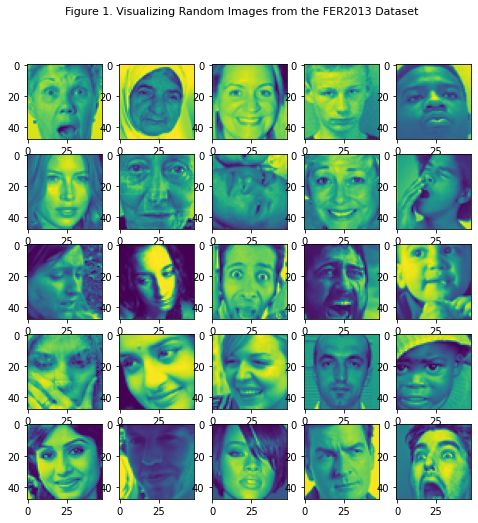

In [2]:
###### LOAD DATA FROM DRIVE 
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

#visualize random samples
fig, axes = plt.subplots(5,5, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[random.randint(0,len(x_train))])

fig.suptitle('Figure 1. Visualizing Random Images from the FER2013 Dataset', fontsize=11)

Text(0.5, 1.0, 'Figure 2. Emotion Class Distribution in Training Data')

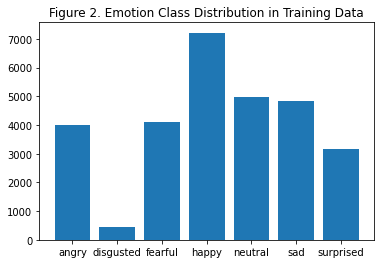

In [3]:
###### CLASS DISTRIBUTION

#visualize class distribution
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts = np.unique(y_train, return_counts=True)
class_dist = {} #true class distribution
for i in range(len(values)):
  class_dist[i] = counts[i]

plt.bar(emotion_dictionary.keys(),class_dist.values())
plt.title("Figure 2. Emotion Class Distribution in Training Data")

<BarContainer object of 7 artists>

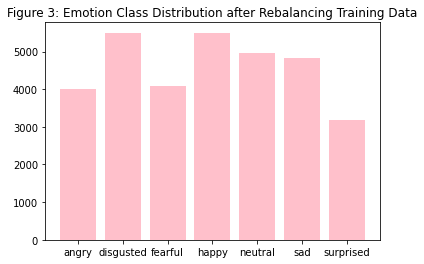

In [4]:
###### FIX CLASS IMBALANCE 

#randomly undersample majority class 
class_undersample =  {0: 3995, 1: 436, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
x_train_reshape = x_train.reshape(len(x_train),48*48)
undersample = RandomUnderSampler(sampling_strategy=class_undersample)
x_train_under, y_train_under = undersample.fit_resample(x_train_reshape,y_train)

#oversample minority class  using k-nearest data augmentation
class_oversample =  {0: 3995, 1: 3500, 2: 4097, 3: 5500, 4: 4965, 5: 4830, 6: 3171}
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train, y_train = sm.fit_resample(x_train_under,y_train_under)

#visualize resampled class distribution 
values, counts_ = np.unique(y_train, return_counts=True)
plt.title("Figure 3: Emotion Class Distribution after Rebalancing Training Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

In [5]:
###### PREPARE DATASET FOR

# both VGG and ResNet require RGB images but FER2013 is grayscale 
#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.2)

#resize to make sure input is the correct shape
x_train = np.resize(x_train, (len(x_train), 48,48,3))
x_val = np.resize(x_val, (len(x_val), 48,48,3))
x_test = np.resize(x_test, (len(x_test), 48,48,3))

print("Sizes of dataset after splitting into train, test, and validation set:")
print('Train -- ', x_train.shape, y_train.shape)
print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)

Sizes of dataset after splitting into train, test, and validation set:
Train --  (32058, 48, 48, 3) (32058,)
Val --  (5742, 48, 48, 3) (5742,)
Test --  (1436, 48, 48, 3) (1436,)


In [6]:
###### DATA AUGMENTATION

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=bs)
    
epochs = 30
bs = 128

train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
val_path = '/content/drive/MyDrive/Capstone/FER2013/val/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_generator  = get_datagen(train_path, True)
val_generator    = get_datagen(val_path)
test_generator  = get_datagen(test_path)

Found 28709 images belonging to 7 classes.
Found 6069 images belonging to 7 classes.
Found 1109 images belonging to 7 classes.


## **ResNet50** 



In [43]:
#Load Pretrained ResNet50 Model 
input_tensor = K.Input(shape=(48,48,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_tensor)

#Freezing Layers 
n_freeze = 165
for layer in res50_model.layers[:n_freeze]:
  layer.trainable =False

#verify that the desired layers are frozen 
for i, layer in enumerate(res50_model.layers):
  if i == 10:
    print("...")
  if i < 10 or i > (n_freeze - 3):  
    print(i,layer.name,'-',layer.trainable)

0 input_7 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
...
163 conv5_block2_add - False
164 conv5_block2_out - False
165 conv5_block3_1_conv - True
166 conv5_block3_1_bn - True
167 conv5_block3_1_relu - True
168 conv5_block3_2_conv - True
169 conv5_block3_2_bn - True
170 conv5_block3_2_relu - True
171 conv5_block3_3_conv - True
172 conv5_block3_3_bn - True
173 conv5_block3_add - True
174 conv5_block3_out - True


In [52]:
## Build the model
model=K.models.Sequential()
model.add(res50_model) #pre-trained model with frozen layers 

# stacking more layers 

model.add(K.layers.Flatten())
model.add(K.layers.Dropout(0.5))
#model.add(K.layers.BatchNormalization())

model.add(K.layers.Dense(4096,kernel_initializer='he_uniform'))
#model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(1024,kernel_initializer='he_uniform'))
#model.add(K.layers.BatchNormalization())
model.add(K.layers.Activation('relu'))
model.add(K.layers.Dropout(0.5))

model.add(K.layers.Dense(7,activation='softmax'))


## Compile Model 
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=.0001, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_32 (Dropout)        (None, 8192)              0         
                                                                 
 dense_33 (Dense)            (None, 4096)              33558528  
                                                                 
 activation_11 (Activation)  (None, 4096)              0         
                                                                 
 dropout_33 (Dropout)        (None, 4096)              0         
                                                                 
 dense_34 (Dense)            (None, 1024)            

In [ ]:
#create path to checkpoint to save model weights
ckpt_path = os.path.join('/content/drive/MyDrive/Capstone/datasets', 'ckpt_res50') 

#reduce learning rate when performance doesn't increase for 5 epochs
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 5,verbose = 1,factor = 0.1, min_lr = 1e-10)
#stop early if performance doesn't increase substantially for 10 epochs
es = EarlyStopping(min_delta=0, verbose=1, patience=15)

#create model checkpoint to save weights
check_point = K.callbacks.ModelCheckpoint(filepath=  ckpt_path,
                                              monitor="val_accuracy",
                                              mode="max",
                                              save_best_only=True,)

#Train the model using min--batch gradient descent
history = model.fit(train_generator, batch_size=32, epochs=100, verbose=1,
                        validation_data=val_generator,
                        max_queue_size=100,
                        workers = 10 ,# (set a proper value > 1)
                        use_multiprocessing=True,
                        callbacks=[lrd, es, check_point])

model.save(ckpt_path)

Epoch 1/100
 13/225 [>.............................] - ETA: 1:01 - loss: 5.0478 - accuracy: 0.1683

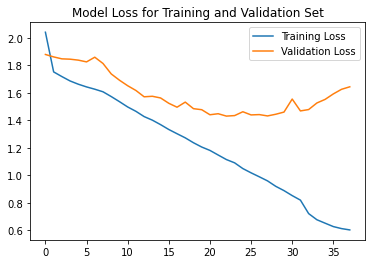

In [46]:
hist = history.history
train_acc = hist['accuracy']
train_loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

plt.title("Model Loss for Training and Validation Set")
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()

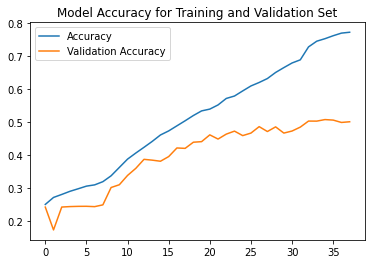

In [47]:
plt.title("Model Accuracy for Training and Validation Set")
plt.plot(train_acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend()

In [48]:
###### TESTING 

loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

45/45 [==============================] - 2s 49ms/step - loss: 1.7556 - accuracy: 0.5049
Restored model, accuracy: 50.49%



## **VGG16**


In [ ]:
vgg = VGG16(weights = 'imagenet', include_top=False, input_shape= (48,48,3))
n_freeze = 19
for layer in vgg.layers[:n_freeze]:
  layer.trainable=False

for (i,layer) in enumerate(vgg.layers):
  print(str(i)+' '+ layer.__class__.__name__, layer.trainable)

def fully_connected(base_model, num_classes):
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  return x

num_class = 7
FC_head = fully_connected(vgg, num_class)
model = Model(inputs=vgg.input, outputs = FC_head)
print(model.summary())

rms_lr = 0.001
sgd_lr = 0.01
adam_lr = 0.001
sgd_decay = 0.0001

sgd = SGD(learning_rate=sgd_lr, momentum=0.9, decay=sgd_decay, nesterov=True) 
adam = Adam(learning_rate=adam_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
rms = RMSprop(learning_rate=rms_lr)

model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator, #x_train, y_train,  
                    epochs=epochs, 
                    verbose=1,
                    validation_data= val_generator, #(x_val, y_val),
                    max_queue_size=100,
                    workers = 10 ,# (set a proper value > 1)
                    use_multiprocessing=True,
                    callbacks=callbacks)

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))